# 구내식당 식수 인원 예측 AI 경진대회
## 7조

[데이터 출처: DACON](https://dacon.io/competitions/official/235743/overview/description)

# 개요

### 데이터

- 구내식당 데이터셋
- 구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측
- 빅데이터 분석을 활용한 정확도 높은 예측을 통해 잔반 발생량의 획기적 감소 목적

### 데이터 특성 구분

- `일자`: 년-월-일 로 구성되어 있는 날짜
- `요일` : 주말을 제외한 평일로 구성되어 있는 요일
- `본사정원수` : 회사의 총 근무 직원 수
- `본사휴가자수` : 해당 근무 일자 중 휴가 직원 수
- `본사출장자수` : 해당 근무 일자 중 출장 중인 직원 수
- `시간외근무명령서승인건수`
- `현본사소속재택근무자수`
- `조식메뉴` : 밥, 국, 반찬 등으로 구성된 조식 메뉴
- `중식메뉴` : 밥, 국, 반찬 등으로 구성된 중식 메뉴
- `석식메뉴` : 밥, 국, 반찬 등으로 구성된 석식 메뉴
- `중식계` : 해당 일자 중식을 먹은 직원의 계
- `석식계` : 해당 일자 석식을 먹은 직원의 계

### 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import koreanize_matplotlib

In [2]:
def split_train_test(data, test_ratio=0.2, suffle=True):
    if test_ratio >= 1:
        raise ValueError("test_ratio is must be less than 1")
        
    if suffle:
        suffled_indices = np.random.permutation(len(data))
        test_set_size = int(len(data) * test_ratio)
        test_indices = suffled_indices[:test_set_size]
        train_indices = suffled_indices[test_set_size:]
        return data.iloc[train_indices], data.iloc[test_indices]
    else:
        train_set_size = int(len(data) * (1 - test_ratio))
        return data.iloc[:train_set_size], data.iloc[train_set_size:]

In [3]:
BASE_PATH = "data/"

In [4]:
original_df= pd.read_csv(BASE_PATH + "/train.csv")

1차적으로 ```train``` / ```test``` 분리

In [5]:
train, test = split_train_test(original_df, suffle=False)
display(train.head(2))
train.shape, test.shape

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


((964, 12), (241, 12))

In [6]:
y_test = pd.DataFrame(test.pop("중식계"))
y_test["석식계"] = test.pop("석식계")
display(test.head(2))
test.shape

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
964,2020-01-14,화,2821,96,236,388,0.0,모닝롤/바나나샌드 우유/주스 스크램블에그 흑임자죽/쌀밥 (쌀:국내산) 감자양파국 ...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 함박스테이크*소스 두부구이 오이무침 포기...,유부초밥 (쌀:국내산) 쌀국수 (양지:호주산) 떡볶이 군만두 귤/음료 포기김치...
965,2020-01-15,수,2821,97,235,4,0.0,모닝롤/치즈프레즐 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 차돌박이찌개 ...,단호박영양밥 (쌀:국내산) 연두부탕 오징어숙회무침 (오징어:원양산) 고기전 (돼지...,쌀밥/잡곡밥 (쌀:국내산) 시금치국 돈육고추장볶음 잡채 파채*소스/쌈무 포기...


(241, 10)

In [7]:
y_test = y_test.reset_index(drop = True)
y_test.head()

,중식계,석식계
0,820.0,272.0
1,633.0,350.0
2,761.0,457.0
3,696.0,344.0
4,1075.0,439.0


편한 전처리를 위해 ``` df``` 로 통합

In [8]:
df = pd.concat([train, test])

## 데이터 전처리 및 EDA

In [9]:
def draw_missing_values_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total / len(df) * 100
    dtypes = df.dtypes
    df_missing = pd.concat([total, percent, dtypes], axis=1, keys=['Count', 'Percent', 'Type'])
    return df_missing

test의 target label들(```중식계```, ```석식계```)를 제외한 나머지 컬럼에는 Null 값이 존재하지 않음

In [10]:
draw_missing_values_table(df)

,Count,Percent,Type
석식계,241,20.0,float64
중식계,241,20.0,float64
석식메뉴,0,0.0,object
중식메뉴,0,0.0,object
조식메뉴,0,0.0,object
현본사소속재택근무자수,0,0.0,float64
본사시간외근무명령서승인건수,0,0.0,int64
본사출장자수,0,0.0,int64
본사휴가자수,0,0.0,int64
본사정원수,0,0.0,int64


In [11]:
df.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [12]:
df.tail(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,NaN,NaN
1204,2021-01-26,화,2983,69,183,551,362.0,모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 ...,쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...,(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기,NaN,NaN


In [13]:
display(df.describe())
display(df.describe(include = "object"))

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,964.000000,964.00000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,889.719917,469.84751
std,171.264404,144.190572,43.532298,246.239651,109.937400,206.212722,137.23013
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.00000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,760.000000,423.00000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,492.50000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1022.250000,549.00000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.00000


,일자,요일,조식메뉴,중식메뉴,석식메뉴
count,1205,1205,1205,1205,1205
unique,1205,5,1204,1198,1168
top,2018-09-13,목,모닝롤/프렌치토스트 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 무채국 김...,쌀밥/잡곡밥 (쌀:국내산) 매운소고기국 유린기 코다리조림 치커리사과무침 포기...,*
freq,1,244,2,2,19


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


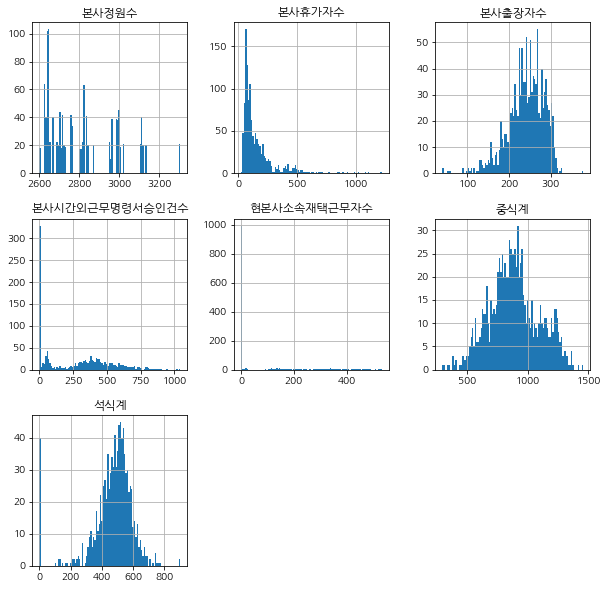

In [14]:
_=df.hist(bins = 100, figsize = (10, 10))

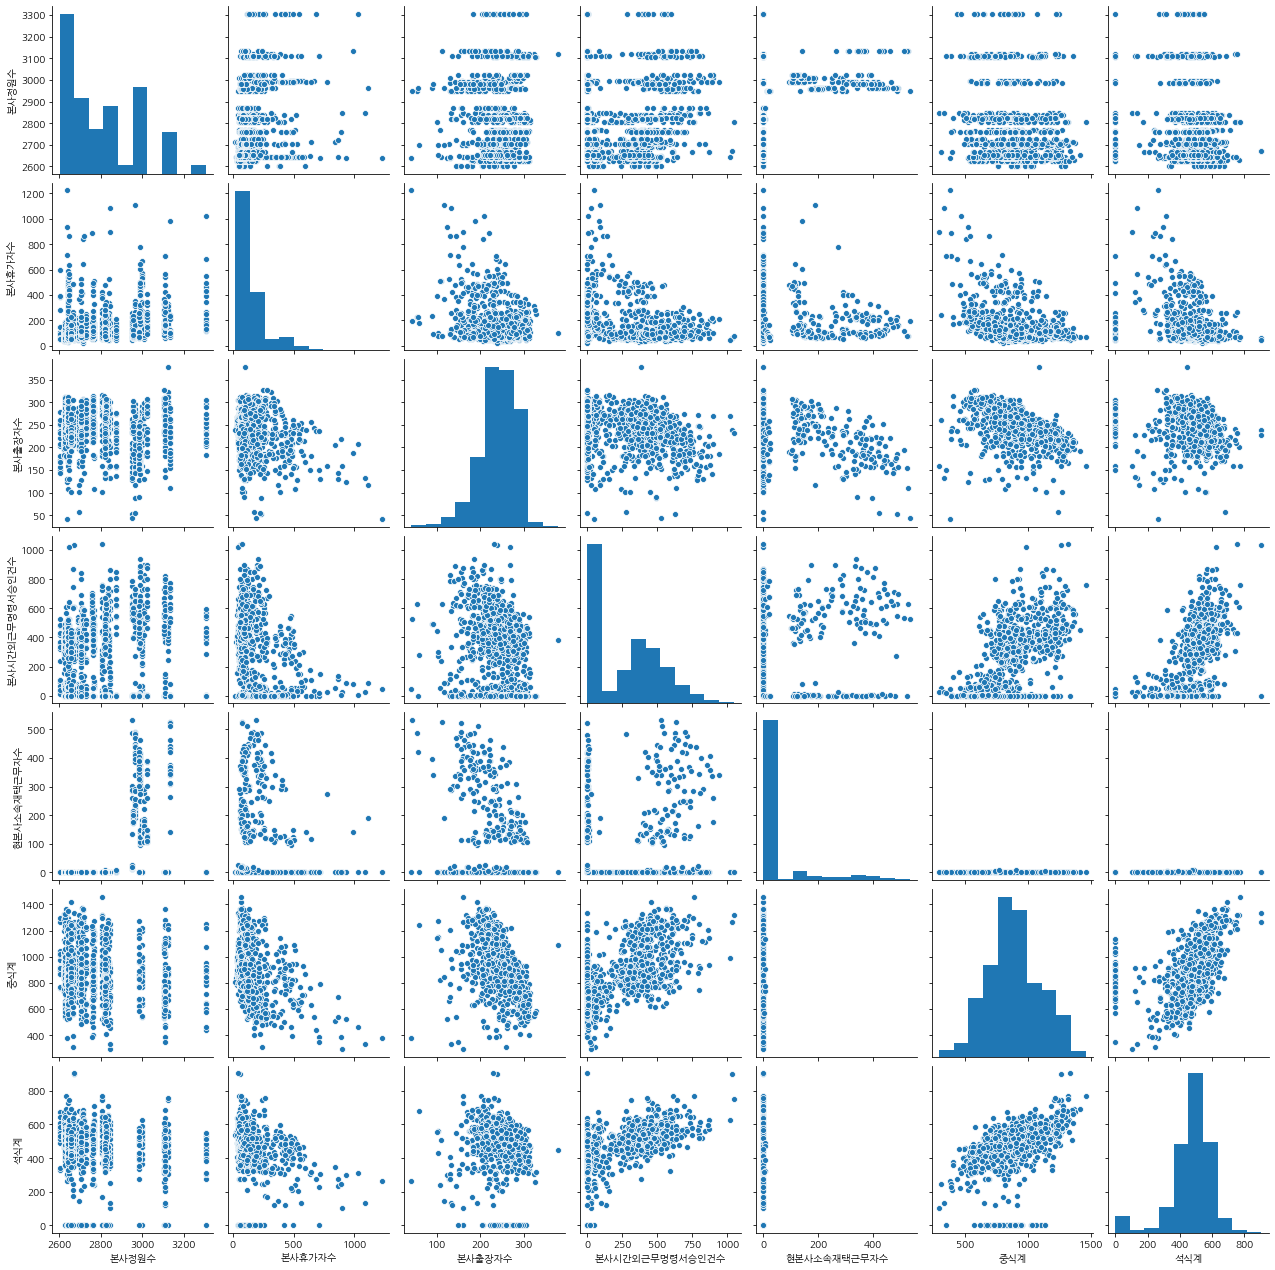

In [15]:
_= sns.pairplot(df)

In [16]:
def corr_with_target(df, target_col = None, size = (12, 8), absolute = False, rtn = False):
    df_corr = df.corr()  
    if absolute:
        df_corr = abs(df_corr)
    
    if target_col == None:
        target_col = df_corr.columns.tolist()
    df_to_plot = df_corr[target_col].drop(index=target_col).sort_values(target_col, ascending = [False] * len(target_col)).T
    plt.figure(figsize = size)
    sns.heatmap(df_to_plot, annot = True, fmt = ".2f", vmin = -1, vmax = 1, cmap = "RdBu_r")
    
    if rtn:
        return df_to_plot.T

```중식계```, ```석식계```와 다른 수치형 변수와의 상관관계

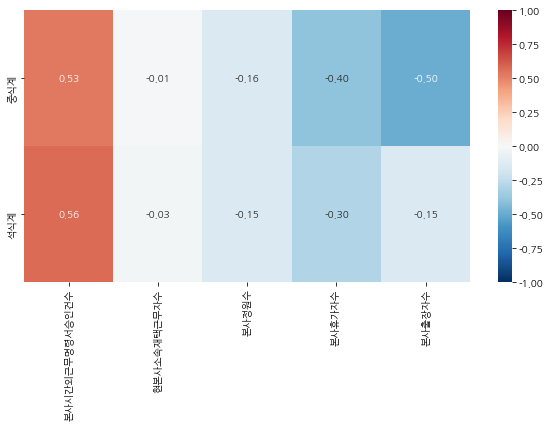

In [17]:
corr_with_target(df, target_col = ["중식계", "석식계"], size = (10, 5), absolute = False)

```일자```로부터 여러 날짜형 변수 추출

In [18]:
def extract_datetime(df, col_name):
    if col_name.encode().isalpha():
        df["year"] = pd.to_datetime(df[col_name]).dt.year
        df["quarter"] = pd.to_datetime(df[col_name]).dt.quarter
        df["month"] = pd.to_datetime(df[col_name]).dt.month
        df["day"] = pd.to_datetime(df[col_name]).dt.day
    else:
        df["연도"] = pd.to_datetime(df[col_name]).dt.year
        df["분기"] = pd.to_datetime(df[col_name]).dt.quarter
        df["월"] = pd.to_datetime(df[col_name]).dt.month
        df["일"] = pd.to_datetime(df[col_name]).dt.day
    return df

In [19]:
df = extract_datetime(df, "일자")
df["연도월"] = pd.to_datetime(df["일자"]).dt.strftime("%Y-%m")
df["연도분기"] = df["연도"].astype('string').str.cat(df["분기"].astype('string'), '-')
df.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,분기,월,일,연도월,연도분기
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,1,2,1,2016-02,2016-1
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,1,2,2,2016-02,2016-1


### 메뉴 전처리

In [20]:
df["조식메뉴"].nunique(), df["중식메뉴"].nunique(), df["석식메뉴"].nunique() ## 일자별로 겹치는 메뉴가 있기는 하지만 거의 다 다름

(1204, 1198, 1168)

In [21]:
df["조식메뉴"].head()

0    모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐...
1    모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌...
2    모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...
3    모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국...
4    모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방...
Name: 조식메뉴, dtype: object

In [22]:
df["조식메뉴"][0]

'모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐어채무침  포기김치 (배추,고추가루:국내산) '

In [23]:
def menu_tolist(string):
    menus = string.split()
    result = []
    for menu in menus:
        if menu[0] != "(" and menu[-1] != ")":
            if "쌀밥" in menu or "흑미밥" in menu or "추가밥" in menu:
                result.append("밥")
            elif "*" in menu:
                result.append(menu.split("*")[0])
            else:
                result.append(menu)

    return result

def make_main_menu(arr):
    main = []
    soup = []
    for menus in arr:
        print(menus)
        if (not menus) or (not menus[0]) or ("자기" in menus[0]) or ("가정의" in menus[0]):
            main.append("없음")
            soup.append("없음")
        else:
            soup.append(menus[1])
            if menus[0] == "밥":
                main.append(menus[2])
            else:
                main.append(menus[0])
        
    return main, soup

main, soup = make_main_menu(df["중식메뉴"].apply(menu_tolist))
df["중식메인"] = main
df["중식국"] = soup
main, soup = make_main_menu(df["석식메뉴"].apply(menu_tolist))
df["석식메인"] = main
df["석식국"] = soup

['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치']
['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이']
['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']
['밥', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치']
['밥', '떡국', '돈육씨앗강정', '우엉잡채', '청경채무침', '요구르트', '포기김치']
['밥', '시래기국', '훈제오리구이', '도토리묵무침', '쌈무/양파절임', '요구르트', '포기김치']
['밥', '꽃게탕', '돈육굴소스볶음', '옥수수전', '유채나물', '요구르트', '포기김치']
['밥', '시금치국', '닭감자조림', '연두부', '콩나물무침', '요구르트', '포기김치']
['밥', '쇠고기무국', '탕수어', '오징어숙회무침', '취나물', '요구르트', '포기김치']
['밥', '냉이된장국', '쇠고기장조림', '통도라지구이', '치커리무침', '요구르트', '포기김치']
['낙지비빔밥', '유부장국', '고구마치즈구이', '해초무침', '요구르트', '요구르트', '포기김치']
['밥', '대구찌개', '마늘간장치킨', '새송이버섯볶음', '돌나물무침/치킨무', '요구르트', '포기김치']
['밥', '쇠고기느타리국', '갈치구이', '호박꼬지&고사리&무나물', '파래김', '부럼/요구르트', '포기김치']
['밥', '콩나물국', '돈육간장볶음', '버섯잡채', '꽃상추무침', '요구르트', '포기김치']
['비빔밥', '팽이장국', '소세지피망볶음', '맛탕', '귤', '요구르트', '포기김치']
['밥', '북어계란국', '닭갈비', '새싹두부구이', '곰피초장', '요구르트', '포기김치']
['밥', '수제비국', '오징어볶음', '계란찜', '도라지초무침', '요구르트', '포기김치']
['밥', '얼갈이된

In [24]:
special_day_idx = df["석식메뉴"].str.contains("의날")
df.loc[special_day_idx, "석식메뉴"]

327            자기계발의날      
346          *자기계발의날*      
366              가정의날      
667          자기계발의날        
706          자기계발의날        
730          자기개발의날        
747        *  자기계발의날  *    
766        *  자기개발의날  *    
786        *  자기계발의날  *    
809        *  자기개발의날  *    
828       *  자기개발의날  *     
853          자기계발의날        
973          자기개발의날        
993          자기개발의날        
Name: 석식메뉴, dtype: object

In [25]:
df.loc[df["중식계"] == 0, "중식메뉴"]

Series([], Name: 중식메뉴, dtype: object)

In [26]:
df.loc[df["석식계"] == 0, "석식메뉴"]

204                                            *        
224                                            *        
244                                             *       
262                                            *        
281                                            *        
306                                            *        
327                                         자기계발의날      
346                                       *자기계발의날*      
366                                           가정의날      
392                                            *        
410    쌀밥/잡곡밥 (쌀:국내산) 된장찌개  미니함박조림  계란말이  비름나물  포기김치 ...
412                                            *        
424                                            *        
449                                            *        
468                                            *        
492                                            *        
502    쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국  고추잡채*꽃빵  계란찜  오이무침  포기김치...
510                            

In [27]:
df.loc[(df["석식계"] == 0 ) & df["석식메뉴"].str.contains("밥"), "석식계"] = df["석식계"].median()

In [28]:
df.loc[(df["석식계"] == 0 ), "석식메뉴"] = "석식없음"
df["석식없음"] = (df["석식메뉴"] == "석식없음").astype(int)

메뉴의 메인과 국에 따른 ```중식계```, ```석식계```의 평균값의 rank를 계산하여 변수로 추출

In [29]:
def calc_rank(df, col_name, key, agg = 'mean'):
    rank = df.groupby(col_name)[key].agg(agg).rank(ascending = False)
    df[f'{col_name}_{key}_{agg}_rank'] = df[col_name].map(rank)
    df[f'{col_name}_{key}_{agg}_rank'] = df[f'{col_name}_{key}_{agg}_rank'].fillna(rank.median())
    return df

In [30]:
for col_name in ['중식메인', '중식국', '석식메인', '석식국', "연도분기", "요일"]:
    df = calc_rank(df, col_name, "중식계", 'mean')
    df = calc_rank(df, col_name, "석식계", 'mean')

In [31]:
df.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,중식국_중식계_mean_rank,중식국_석식계_mean_rank,석식메인_중식계_mean_rank,석식메인_석식계_mean_rank,석식국_중식계_mean_rank,석식국_석식계_mean_rank,연도분기_중식계_mean_rank,연도분기_석식계_mean_rank,요일_중식계_mean_rank,요일_석식계_mean_rank
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,17.0,169.0,215.0,250.0,107.0,165.0,3.0,1.0,1.0,1.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,54.0,26.5,83.0,82.0,95.0,101.0,3.0,1.0,2.0,2.0


## 머신러닝 모델링
### 모델에 들어가 변수 설정

In [32]:
df.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '연도', '분기', '월',
       '일', '연도월', '연도분기', '중식메인', '중식국', '석식메인', '석식국', '석식없음',
       '중식메인_중식계_mean_rank', '중식메인_석식계_mean_rank', '중식국_중식계_mean_rank',
       '중식국_석식계_mean_rank', '석식메인_중식계_mean_rank', '석식메인_석식계_mean_rank',
       '석식국_중식계_mean_rank', '석식국_석식계_mean_rank', '연도분기_중식계_mean_rank',
       '연도분기_석식계_mean_rank', '요일_중식계_mean_rank', '요일_석식계_mean_rank'],
      dtype='object')

전처리 후 ```train```/```test``` 재분리

In [33]:
train, test = split_train_test(df, suffle=False)
display(train.head(2)), display(test.head(2))

train.shape, test.shape

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,중식국_중식계_mean_rank,중식국_석식계_mean_rank,석식메인_중식계_mean_rank,석식메인_석식계_mean_rank,석식국_중식계_mean_rank,석식국_석식계_mean_rank,연도분기_중식계_mean_rank,연도분기_석식계_mean_rank,요일_중식계_mean_rank,요일_석식계_mean_rank
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,17.0,169.0,215.0,250.0,107.0,165.0,3.0,1.0,1.0,1.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,54.0,26.5,83.0,82.0,95.0,101.0,3.0,1.0,2.0,2.0


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,중식국_중식계_mean_rank,중식국_석식계_mean_rank,석식메인_중식계_mean_rank,석식메인_석식계_mean_rank,석식국_중식계_mean_rank,석식국_석식계_mean_rank,연도분기_중식계_mean_rank,연도분기_석식계_mean_rank,요일_중식계_mean_rank,요일_석식계_mean_rank
964,2020-01-14,화,2821,96,236,388,0.0,모닝롤/바나나샌드 우유/주스 스크램블에그 흑임자죽/쌀밥 (쌀:국내산) 감자양파국 ...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 함박스테이크*소스 두부구이 오이무침 포기...,유부초밥 (쌀:국내산) 쌀국수 (양지:호주산) 떡볶이 군만두 귤/음료 포기김치...,...,60.0,123.0,129.0,45.5,91.0,87.0,15.0,17.0,2.0,2.0
965,2020-01-15,수,2821,97,235,4,0.0,모닝롤/치즈프레즐 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 차돌박이찌개 ...,단호박영양밥 (쌀:국내산) 연두부탕 오징어숙회무침 (오징어:원양산) 고기전 (돼지...,쌀밥/잡곡밥 (쌀:국내산) 시금치국 돈육고추장볶음 잡채 파채*소스/쌈무 포기...,...,93.0,99.0,2.0,3.5,177.0,152.5,15.0,17.0,3.0,5.0


((964, 35), (241, 35))

In [34]:
label_names = ["중식계", "석식계"]

feature engineering 후 변수들과의 상관크기 확인(절대값)

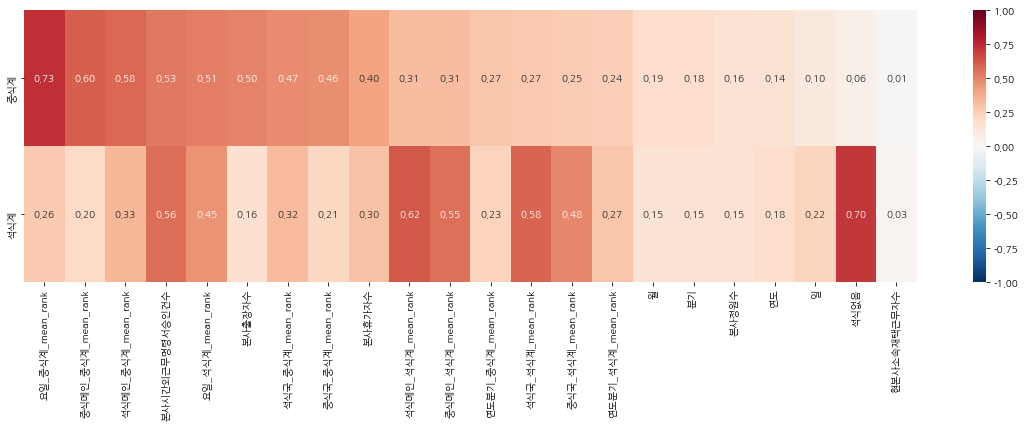

In [35]:
corr_mat = corr_with_target(df, target_col = label_names, size = (20, 5), absolute = True, rtn = True)

In [36]:
corr_mat

,중식계,석식계
요일_중식계_mean_rank,0.734024,0.263406
중식메인_중식계_mean_rank,0.595876,0.198745
석식메인_중식계_mean_rank,0.575981,0.329625
본사시간외근무명령서승인건수,0.527860,0.562290
요일_석식계_mean_rank,0.508094,0.451887
본사출장자수,0.497746,0.162214
석식국_중식계_mean_rank,0.474572,0.315893
중식국_중식계_mean_rank,0.461192,0.213698
본사휴가자수,0.403945,0.295695
석식메인_석식계_mean_rank,0.311116,0.624250


인원에 관한 변수들과 feature engineering으로 얻어진 변수들을 최종 feature로 결정

In [37]:
feature_names = train.columns[train.columns.str.contains('수|mean|석식없음')].tolist()
feature_names

['본사정원수',
 '본사휴가자수',
 '본사출장자수',
 '본사시간외근무명령서승인건수',
 '현본사소속재택근무자수',
 '석식없음',
 '중식메인_중식계_mean_rank',
 '중식메인_석식계_mean_rank',
 '중식국_중식계_mean_rank',
 '중식국_석식계_mean_rank',
 '석식메인_중식계_mean_rank',
 '석식메인_석식계_mean_rank',
 '석식국_중식계_mean_rank',
 '석식국_석식계_mean_rank',
 '연도분기_중식계_mean_rank',
 '연도분기_석식계_mean_rank',
 '요일_중식계_mean_rank',
 '요일_석식계_mean_rank']

In [38]:
X_train = train[feature_names]
X_test = test[feature_names].reset_index(drop = True)
y_train = train[label_names]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((964, 18), (964, 2), (241, 18), (241, 2))

### DNN 모델
예측치 두개를 각각 예측하기 위해 1개의 Ouput을 가지는 ```model```을 만들고 ```model_lnch```, ```model_dnr```로 clone함

In [39]:
import tensorflow as tf

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape =[len(X_train.keys())]),
    tf.keras.layers.Dense(128, activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'relu'), 
    tf.keras.layers.Dense(16, activation = 'swish'),
    tf.keras.layers.Dense(1), 

])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                        

In [42]:
model_lnch = tf.keras.models.clone_model(model)
model_dnr = tf.keras.models.clone_model(model)

In [43]:
# dir(tf.optimizers)

In [44]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-2,
                                                          decay_steps = 10000,
                                                          decay_rate = 0.9)

In [45]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
)

In [46]:
model_lnch.compile(optimizer= optimizer, loss = "mae", metrics=["mse","mae"])
model_dnr.compile(optimizer= optimizer, loss = "mae", metrics=["mse","mae"])

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 100)

In [48]:
history_lnch = model_lnch.fit(X_train, y_train["중식계"], epochs= 300, batch_size = 32, validation_split= 0.3,  callbacks= [early_stop],  verbose = 0)
history_dnr = model_dnr.fit(X_train, y_train["석식계"], epochs= 300, batch_size = 32, validation_split= 0.3,  callbacks= [early_stop],  verbose = 0)

In [49]:
df_hist_lnch = pd.DataFrame(history_lnch.history)
df_hist_lnch.tail()

,loss,mse,mae,val_loss,val_mse,val_mae
276,80.591393,10518.811523,80.591393,84.433426,11825.187500,84.433426
277,76.986992,9816.848633,76.986992,88.859451,13881.864258,88.859451
278,72.897026,9000.025391,72.897026,76.239098,10395.768555,76.239098
279,79.983307,10956.969727,79.983307,107.229538,17195.007812,107.229538
280,79.334732,10121.867188,79.334732,85.169724,12195.599609,85.169724


In [50]:
df_hist_dnr = pd.DataFrame(history_dnr.history)
df_hist_dnr.tail()

,loss,mse,mae,val_loss,val_mse,val_mae
295,60.811798,8506.635742,60.811798,177.011047,43924.765625,177.011047
296,60.243961,7940.818359,60.243961,149.198822,34265.996094,149.198822
297,61.808239,8429.915039,61.808239,102.994682,20642.898438,102.994682
298,58.034420,6885.025391,58.034420,97.615250,18073.275391,97.615250
299,59.157478,7022.600098,59.157478,103.260117,17213.845703,103.260117


In [51]:
y_predict = pd.DataFrame(np.column_stack((model_lnch.predict(X_test), model_dnr.predict(X_test))), columns = label_names)

In [52]:
display(y_test, y_predict)

,중식계,석식계
0,820.0,272.0
1,633.0,350.0
2,761.0,457.0
3,696.0,344.0
4,1075.0,439.0
...,...,...
236,1093.0,421.0
237,832.0,353.0
238,579.0,217.0
239,1145.0,502.0


,중식계,석식계
0,979.236877,587.051208
1,852.728516,495.964417
2,949.932983,580.531128
3,618.115173,439.085266
4,1088.440063,588.254211
...,...,...
236,908.092285,587.366699
237,960.169861,647.613464
238,657.177429,560.393799
239,1259.109131,680.924133


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'중식계'}>,
        <AxesSubplot:title={'center':'석식계'}>]], dtype=object)

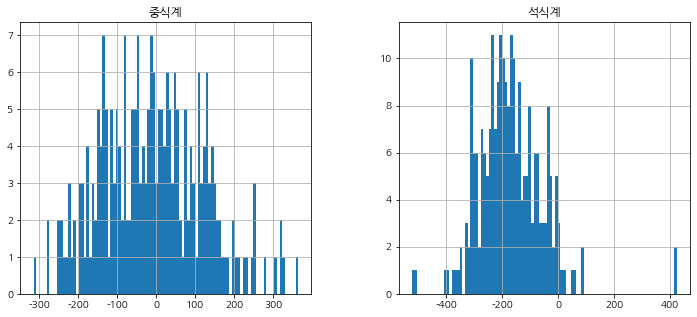

In [53]:
error = (y_test -  y_predict)
error.hist(bins = 100, figsize = (12, 5))

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col f

<AxesSubplot:>

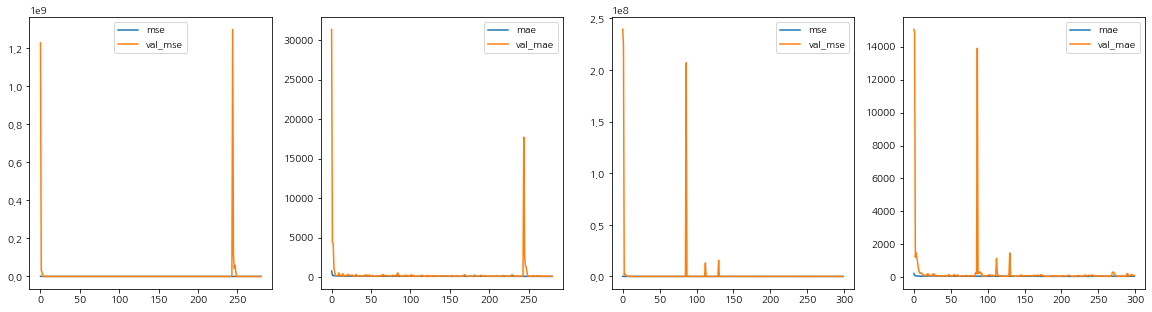

In [54]:
fig, axes = plt.subplots(1, 4, figsize= (20, 5))

df_hist_lnch[["mse", "val_mse"]].plot(ax = axes[0])
df_hist_lnch[["mae", "val_mae"]].plot(ax = axes[1])
df_hist_dnr[["mse", "val_mse"]].plot(ax = axes[2])
df_hist_dnr[["mae", "val_mae"]].plot(ax = axes[3])

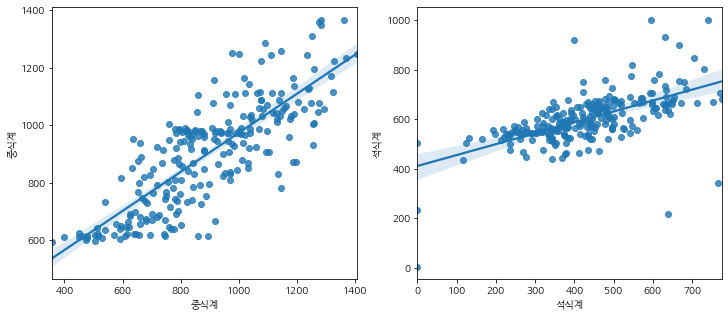

In [55]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
_=sns.regplot(x = y_test["중식계"], y = y_predict["중식계"], ax = axes[0])
_=sns.regplot(x = y_test["석식계"], y = y_predict["석식계"], ax = axes[1])

In [56]:
loss, mae, mse = model_lnch.evaluate(X_test, y_test["중식계"])
print("loss {:5.2f}, mse {:5.2f}, mae {:5.2f}".format(loss, mse, mae))

8/8 [==============================] - 0s 1ms/step - loss: 106.6713 - mse: 17228.6738 - mae: 106.6713
loss 106.67, mse 106.67, mae 17228.67


In [57]:
loss, mae, mse = model_dnr.evaluate(X_test, y_test["석식계"])
print("loss {:5.2f}, mse {:5.2f}, mae {:5.2f}".format(loss, mse, mae))

8/8 [==============================] - 0s 1ms/step - loss: 180.5631 - mse: 42375.7695 - mae: 180.5631
loss 180.56, mse 180.56, mae 42375.77


In [58]:
from sklearn.metrics import r2_score
print(r2_score(y_test["중식계"], y_predict["중식계"]), r2_score(y_test["석식계"], y_predict["석식계"]))

0.6509154130721165 -1.0957868067869816


### Random Forest model
머신러닝 모델과의 비교를 위해...

In [59]:
from sklearn.ensemble import RandomForestRegressor
RF_lnch = RandomForestRegressor(random_state = 42, n_estimators = 1000, max_depth = 1000, n_jobs = -1, max_features = 0.8)
RF_dnr = RandomForestRegressor(random_state = 42, n_estimators = 1000, max_depth = 1000, n_jobs = -1, max_features = 0.8)

In [60]:
RF_lnch.fit(X_train, y_train["중식계"])
RF_dnr.fit(X_train, y_train["석식계"])

RandomForestRegressor(max_depth=1000, max_features=0.8, n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [61]:
y_predict_RF = pd.DataFrame(np.column_stack((RF_lnch.predict(X_test), RF_dnr.predict(X_test))), columns = label_names)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'중식계'}>,
        <AxesSubplot:title={'center':'석식계'}>]], dtype=object)

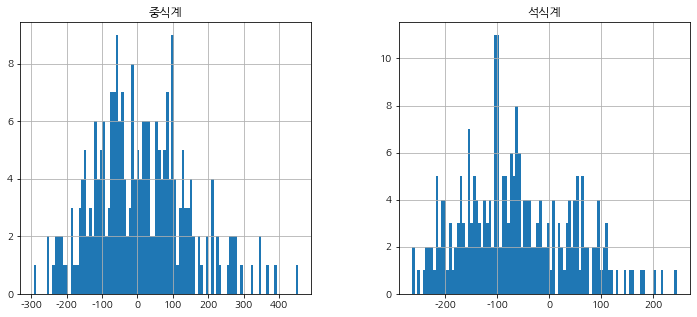

In [62]:
error = (y_test -  y_predict_RF)
error.hist(bins = 100, figsize = (12, 5))

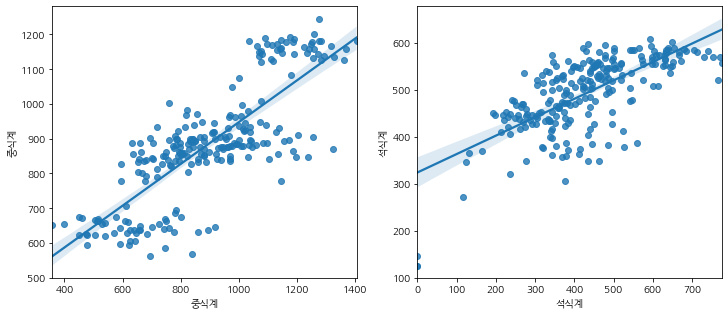

In [63]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
_=sns.regplot(x = y_test["중식계"], y = y_predict_RF["중식계"], ax = axes[0])
_=sns.regplot(x = y_test["석식계"], y = y_predict_RF["석식계"], ax = axes[1])

In [64]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_predict_RF)

104.97770746887966

In [65]:
print(r2_score(y_test["중식계"], y_predict_RF["중식계"]), r2_score(y_test["석식계"], y_predict_RF["석식계"]))

0.6391561452851912 0.26816073858835476


<AxesSubplot:>

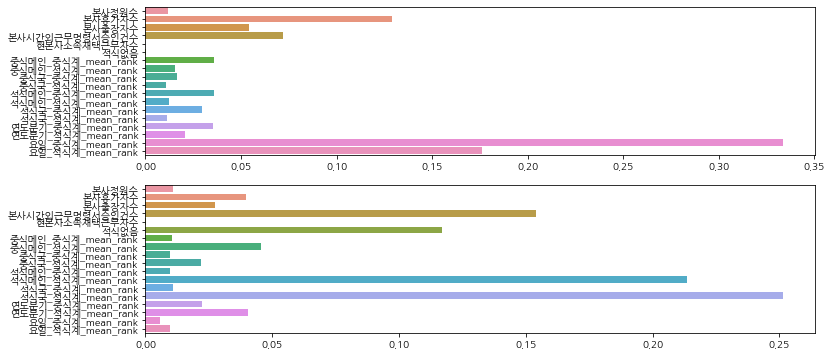

In [66]:
fig, axes = plt.subplots(2,1, figsize = (12 , 6))
sns.barplot(x = RF_lnch.feature_importances_, y = X_train.columns.tolist(), ax = axes[0])
sns.barplot(x = RF_dnr.feature_importances_, y = X_train.columns.tolist(), ax = axes[1])

## 마치며

재밌는 주제의 데이터 분석이었지만 아직 DNN에 대한 이해가 부족해서인지, 생각보다 모델의 예측 능력이 (Random Forest보다도) 좋지 않아서 조금 답답한 프로젝트였던 것 같다.
모델 예측력이 좋으면 모델을 활용한 예측 서비스를 구현해보고 싶었는데, 그렇지 못해서 아쉽고 많은 시행착오를 겪으면서 모델을 개선하는 연습이 필요할 것 같다.